# Matrix Factorization (MF) part 2: Getting Fancy
Demonstrates matrix factorization with MXNet on the [MovieLens 100k](http://grouplens.org/datasets/movielens/100k/) dataset.  This is an extension of [part 1](demo1-MF.ipynb) where we try fancy optimizers and network structures.

You need to have python package pandas and bokeh installed (pip install pandas bokeh).

In [1]:
import mxnet as mx
from movielens_data import get_data_iter, max_id
from matrix_fact import train
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
# If MXNet is not compiled with GPU support (e.g. on OSX), set to [mx.cpu(0)]
# Can be changed to [mx.gpu(0), mx.gpu(1), ..., mx.gpu(N-1)] if there are N GPUs
ctx = mx.cpu() #[mx.gpu(0)]

In [3]:
train_test_data = get_data_iter(batch_size=100)
max_user, max_item = max_id('./ml-100k/u.data')
(max_user, max_item)

(944, 1683)

## Linear MF
Same as before, but this time with the [Adam optimizer](https://arxiv.org/abs/1412.6980) which will often converge much faster than SGD w/ momentum as we used before.  You should see this model over-fitting quickly. 

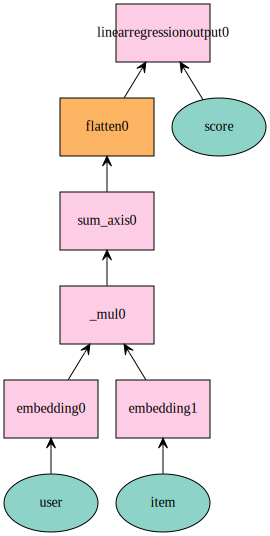

In [4]:
def plain_net(k):
    # input
    user = mx.symbol.Variable('user')
    item = mx.symbol.Variable('item')
    score = mx.symbol.Variable('score')
    # user feature lookup
    user = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k) 
    # item feature lookup
    item = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
    # predict by the inner product, which is elementwise product and then sum
    pred = user * item
    pred = mx.symbol.sum_axis(data = pred, axis = 1)
    pred = mx.symbol.Flatten(data = pred)
    # loss layer
    pred = mx.symbol.LinearRegressionOutput(data = pred, label = score)
    return pred

net1 = plain_net(64)
mx.viz.plot_network(net1)

In [5]:
results1 = train(net1, train_test_data, num_epoch=25, learning_rate=0.001, optimizer='adam', ctx=ctx)

matrix_fact.py:56: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **opt_args
/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/model.py:547: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [500]	Speed: 16275.51 samples/sec	RMSE=3.072278
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=2.565
INFO:root:Epoch[0] Validation-RMSE=1.444391
INFO:root:Epoch[1] Batch [500]	Speed: 16613.15 samples/sec	RMSE=1.186159
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=2.509
INFO:root:Epoch[1] Validation-RMSE=1.102464
INFO:root:Epoch[2] Batch [500]	Speed: 15440.85 samples/sec	RMSE=1.024542
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=2.599
INFO:root:Epoch[2] Validation-RM

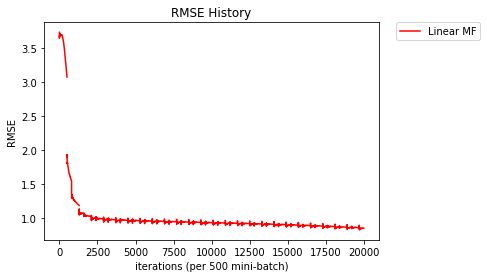

In [6]:
plt.plot(results1,'r',label='Linear MF')
plt.ylabel('RMSE')
plt.xlabel('iterations (per 500 mini-batch)')
plt.title("RMSE History")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Neural Network (non-linear) MF
The non-linear model converges strangely with Adam.

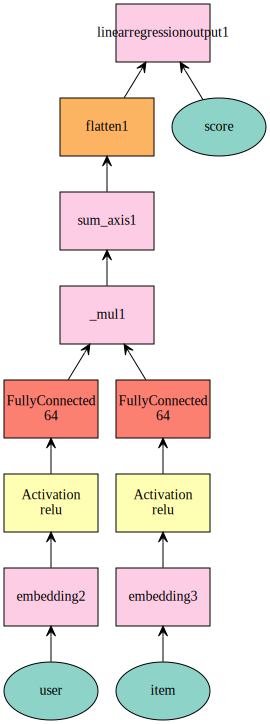

In [7]:
def get_one_layer_mlp(hidden, k):
    # input
    user = mx.symbol.Variable('user')
    item = mx.symbol.Variable('item')
    score = mx.symbol.Variable('score')
    # user latent features
    user = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k)
    user = mx.symbol.Activation(data = user, act_type='relu')
    user = mx.symbol.FullyConnected(data = user, num_hidden = hidden)
    # item latent features
    item = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
    item = mx.symbol.Activation(data = item, act_type='relu')
    item = mx.symbol.FullyConnected(data = item, num_hidden = hidden)
    # predict by the inner product
    pred = user * item
    pred = mx.symbol.sum_axis(data = pred, axis = 1)
    pred = mx.symbol.Flatten(data = pred)
    # loss layer
    pred = mx.symbol.LinearRegressionOutput(data = pred, label = score)
    return pred

net2 = get_one_layer_mlp(64, 64)
mx.viz.plot_network(net2)

In [8]:
results2 = train(net2, train_test_data, num_epoch=20, learning_rate=0.001, optimizer='adam', ctx=ctx)

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [500]	Speed: 12196.88 samples/sec	RMSE=1.376559
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=3.553
INFO:root:Epoch[0] Validation-RMSE=0.989484
INFO:root:Epoch[1] Batch [500]	Speed: 11949.21 samples/sec	RMSE=0.960052
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=3.590
INFO:root:Epoch[1] Validation-RMSE=0.982818
INFO:root:Epoch[2] Batch [500]	Speed: 10528.84 samples/sec	RMSE=0.954273
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=3.779
INFO:root:Epoch[2] Validation-RMSE=0.984650
INFO:root:Epoch[3] Batch [500]	Speed: 10890.96 samples/sec	RMSE=0.954112
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=3.679
INFO:root:Epoch[3] Validation-RMSE=0.986031
INFO:root:Epoch[4] Batch [500]	Speed: 11022.89 samples/sec	RMSE=0.952295
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=3.760
INFO:root:Epoch[4] Validation-

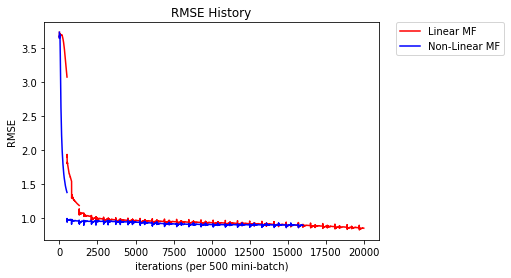

In [9]:
plt.plot(results1,'r',label='Linear MF')
plt.plot(results2,'b',label='Non-Linear MF')

plt.ylabel('RMSE')
plt.xlabel('iterations (per 500 mini-batch)')
plt.title("RMSE History")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Deep Neural Network (Residual Network / ResNet)
Borrowing ideas from [Deep Residual Learning for Image Recognition (He, et al.)](https://arxiv.org/abs/1512.03385) to build a complex deep network that is aggressively regularized to avoid over-fitting, but still achieves good performance. 

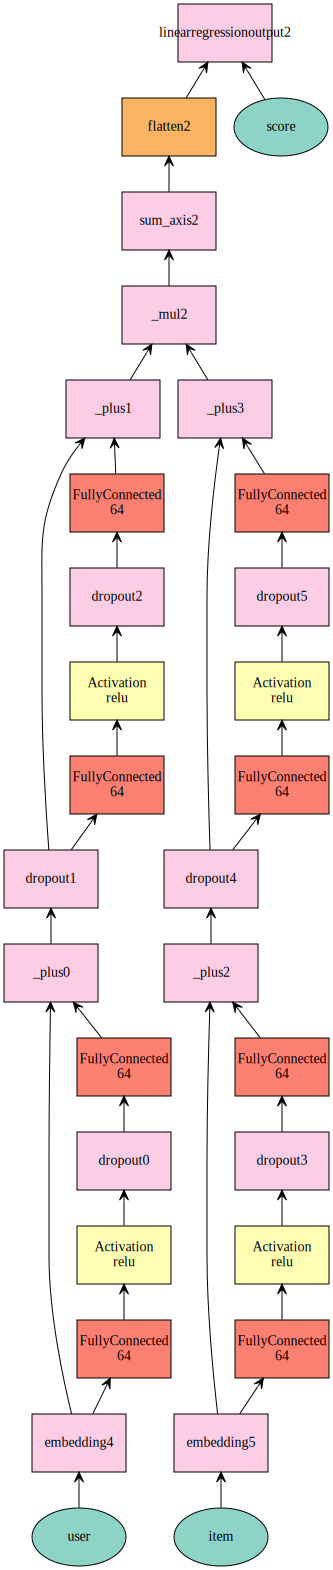

In [10]:
def get_multi_layer_dropout_resnet(hidden, k):
    # input
    user = mx.symbol.Variable('user')
    item = mx.symbol.Variable('item')
    score = mx.symbol.Variable('score')
    # user latent features
    user1 = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k)
    user = mx.symbol.FullyConnected(data = user1, num_hidden = hidden)
    user = mx.symbol.Activation(data = user, act_type='relu')
    user = mx.symbol.Dropout(data=user, p=0.5)
    user = mx.symbol.FullyConnected(data = user, num_hidden = hidden)
    user2 = user + user1
    user2 = mx.symbol.Dropout(data=user2, p=0.5)
    user = mx.symbol.FullyConnected(data = user2, num_hidden = hidden)
    user = mx.symbol.Activation(data = user, act_type='relu')
    user = mx.symbol.Dropout(data=user, p=0.5)
    user = mx.symbol.FullyConnected(data = user, num_hidden = hidden)
    user = user + user2
    # item latent features
    item1 = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
    item = mx.symbol.FullyConnected(data = item1, num_hidden = hidden)
    item = mx.symbol.Activation(data = item, act_type='relu')
    item = mx.symbol.Dropout(data=item, p=0.5)    
    item = mx.symbol.FullyConnected(data=item, num_hidden = hidden)
    item2 = item + item1
    item2 = mx.symbol.Dropout(data=item2, p=0.5)    
    item = mx.symbol.FullyConnected(data = item2, num_hidden = hidden)
    item = mx.symbol.Activation(data = item, act_type='relu')
    item = mx.symbol.Dropout(data=item, p=0.5)    
    item = mx.symbol.FullyConnected(data=item, num_hidden = hidden)
    item = item + item2
    # predict by the inner product
    pred = user * item
    pred = mx.symbol.sum_axis(data = pred, axis = 1)
    pred = mx.symbol.Flatten(data = pred)
    # loss layer
    pred = mx.symbol.LinearRegressionOutput(data = pred, label = score)
    return pred
net3 = get_multi_layer_dropout_resnet(64, 64)
mx.viz.plot_network(net3)

In [11]:
# Larger batch size makes GPU more efficient for this complex model
train_test_data2 = get_data_iter(batch_size=200) 
results3 = train(net3, train_test_data2, num_epoch=25, learning_rate=0.001, optimizer='adam', ctx=ctx)

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=3.106
INFO:root:Epoch[0] Validation-RMSE=0.977007
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=3.489
INFO:root:Epoch[1] Validation-RMSE=0.967159
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=3.098
INFO:root:Epoch[2] Validation-RMSE=0.961666
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=5.531
INFO:root:Epoch[3] Validation-RMSE=0.959961
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=11.078
INFO:root:Epoch[4] Validation-RMSE=0.958688
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=9.982
INFO:root:Epoch[5] Validation-RMSE=0.958289
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=10.033
INFO:root:Epoch[6] Validation-RMSE=0.957023
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=9.975
INFO:root:Epoch[7] Validati

## Visualizing results
Compare accuracy and training time across the models.

In [ ]:
import bokeh
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import pandas as pd

def viz_lines(fig, results, legend, color):
    df = pd.DataFrame(results._data['eval'])
    fig.line(df.elapsed,df.RMSE, color=color, legend=legend, line_width=2)
    df = pd.DataFrame(results._data['train'])
    fig.line(df.elapsed,df.RMSE, color=color, line_dash='dotted', alpha=0.1)

fig = bokeh.plotting.Figure(x_axis_type='datetime', x_axis_label='Training time', y_axis_label='RMSE')
viz_lines(fig, results1, "Linear MF", "orange")
viz_lines(fig, results2, "MLP", "blue")
viz_lines(fig, results3, "ResNet", "red")

bokeh.io.show(fig)

In [12]:
import bokeh
print(bokeh.__version__)

0.12.10
